In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [57]:
# ----------------- Load -----------------
df = pd.read_csv("E:/Project_CloudThat/12 month+1data.csv")

#  Basic structure and summary
print("Shape of dataset:", df.shape)
print("\nColumns and Data Types:\n", df.dtypes)
print("\nFirst 5 rows:\n", df.head())
print("\nInfo:")
df.info()



Shape of dataset: (185950, 6)

Columns and Data Types:
 Order ID              int64
Product              object
Quantity Ordered      int64
Price Each          float64
Order Date           object
Purchase Address     object
dtype: object

First 5 rows:
    Order ID                     Product  Quantity Ordered  Price Each  \
0    176558        USB-C Charging Cable                 2       11.95   
1    176559  Bose SoundSport Headphones                 1       99.99   
2    176560                Google Phone                 1      600.00   
3    176560            Wired Headphones                 1       11.99   
4    176561            Wired Headphones                 1       11.99   

         Order Date                      Purchase Address  
0    04/19/19 08:46          917 1st St, Dallas, TX 75001  
1  04-07-2019 22:30     682 Chestnut St, Boston, MA 02215  
2  04-12-2019 14:38  669 Spruce St, Los Angeles, CA 90001  
3  04-12-2019 14:38  669 Spruce St, Los Angeles, CA 90001  
4    04

In [59]:
# Statistical Overview
print("\nDescribe():")
print(df.describe(include="all"))

#  Missing Values
print("\nMissing values per column:\n", df.isnull().sum())

#  Duplicates
print("\nNumber of duplicate rows:", df.duplicated().sum())

# Unique Values
print("\nUnique values per column:\n", df.nunique())




Describe():
             Order ID               Product  Quantity Ordered     Price Each  \
count   185950.000000                185950     185950.000000  185950.000000   
unique            NaN                    19               NaN            NaN   
top               NaN  USB-C Charging Cable               NaN            NaN   
freq              NaN                 21903               NaN            NaN   
mean    230417.569379                   NaN          1.124383     184.399735   
std      51512.737110                   NaN          0.442793     332.731330   
min     141234.000000                   NaN          1.000000       2.990000   
25%     185831.250000                   NaN          1.000000      11.950000   
50%     230367.500000                   NaN          1.000000      14.950000   
75%     275035.750000                   NaN          1.000000     150.000000   
max     319670.000000                   NaN          9.000000    1700.000000   

            Order Date    

In [61]:
# ----------------- Cleaning -----------------

#  Remove duplicate rows
df = df.drop_duplicates()

#  Convert 'Order Date' to datetime format 
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')

#  Drop rows where date conversion failed (NaT)
df = df.dropna(subset=['Order Date'])

# Ensure numeric types 
df['Quantity Ordered'] = pd.to_numeric(df['Quantity Ordered'], errors='coerce')
df['Price Each'] = pd.to_numeric(df['Price Each'], errors='coerce')
df = df.dropna(subset=['Quantity Ordered', 'Price Each'])

#  Standardize product names
df['Product'] = df['Product'].astype(str).str.strip().str.title()

print("\nAfter basic cleaning:")
print("New shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())
display(df.head())




After basic cleaning:
New shape: (185686, 6)

Missing values:
 Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

Duplicate rows: 0


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,Usb-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001"
1,176559,Bose Soundsport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215"
2,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001"
3,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001"
4,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001"


In [63]:
# ----------------- Feature Engineering -----------------
df_cleaned = df.copy()

# Extract datetime components
df_cleaned['Year'] = df_cleaned['Order Date'].dt.year
df_cleaned['Month'] = df_cleaned['Order Date'].dt.month
df_cleaned['Day'] = df_cleaned['Order Date'].dt.day
df_cleaned['Weekday'] = df_cleaned['Order Date'].dt.day_name()
df_cleaned['Hour'] = df_cleaned['Order Date'].dt.hour



In [65]:
#  Create Total Price
df_cleaned['Total Price'] = df_cleaned['Quantity Ordered'] * df_cleaned['Price Each']

#  Extract city, state, and zip code from address 
addr = df_cleaned['Purchase Address'].astype(str).str.split(',')
df_cleaned['City'] = addr.str[1].str.strip()
state_zip = addr.str[2].str.split()
df_cleaned['State'] = state_zip.str[0]
df_cleaned['Zip Code'] = state_zip.str[1]



In [67]:
# Product Count per transaction
if 'Order ID' in df_cleaned.columns:
    df_cleaned['Product Count'] = df_cleaned.groupby('Order ID')['Order ID'].transform('count')
else:
    df_cleaned['Product Count'] = 1



In [75]:
# Product Type: basic categorization based on keywords
def get_product_type(product):
    product = str(product).lower()
    if 'phone' in product:
        return 'Phone'
    elif 'headphone' in product or 'ear' in product:
        return 'Audio'
    elif 'charger' in product or 'cable' in product:
        return 'Accessory'
    elif 'monitor' in product or 'screen' in product:
        return 'Display'
    elif 'macbook' in product or 'laptop' in product:
        return 'Laptop'
    elif 'keyboard' in product or 'mouse' in product:
        return 'Input'
    else:
        return 'Other'

# Corrected line: create Product Type from Product
df_cleaned['Product Type'] = df_cleaned['Product'].astype(str).apply(get_product_type)

# Season from month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df_cleaned['Season'] = df_cleaned['Month'].apply(get_season)

# Seasonal Product flag
def seasonal_flag(row):
    p = str(row['Product']).lower()
    m = row['Month']
    if 'heater' in p and m in [12, 1, 2]:
        return 1
    elif 'fan' in p and m in [6, 7, 8]:
        return 1
    else:
        return 0

df_cleaned['Seasonal Product'] = df_cleaned.apply(seasonal_flag, axis=1)

# Preview final engineered features
display(df_cleaned[['Product', 'Product Type', 'Month', 'Season', 'Seasonal Product', 'Total Price', 'Product Count']].head())



,Product,Product Type,Month,Season,Seasonal Product,Total Price,Product Count
0,Usb-C Charging Cable,Accessory,4,Spring,0,23.90,1
1,Bose Soundsport Headphones,Phone,4,Spring,0,99.99,1
2,Google Phone,Phone,4,Spring,0,600.00,2
3,Wired Headphones,Phone,4,Spring,0,11.99,2
4,Wired Headphones,Phone,4,Spring,0,11.99,1


In [77]:

try:
    df_cleaned
except NameError:
    df_cleaned = df.copy()

# Clean column names
df_cleaned.columns = df_cleaned.columns.str.strip()

# Create Product Type if missing
if 'Product Type' not in df_cleaned.columns:
    def get_product_type(product):
        p = str(product).lower()
        if 'phone' in p: return 'Phone'
        if 'headphone' in p or 'ear' in p: return 'Audio'
        if 'charger' in p or 'cable' in p: return 'Accessory'
        if 'monitor' in p or 'screen' in p: return 'Display'
        if 'macbook' in p or 'laptop' in p: return 'Laptop'
        if 'keyboard' in p or 'mouse' in p: return 'Input'
        return 'Other'
    # ensure Product text is normalized
    df_cleaned['Product'] = df_cleaned['Product'].astype(str).str.strip().str.title()
    df_cleaned['Product Type'] = df_cleaned['Product'].apply(get_product_type)

# If Product Type still has NaNs, fill for plotting
df_cleaned['Product Type'] = df_cleaned['Product Type'].fillna('Other')

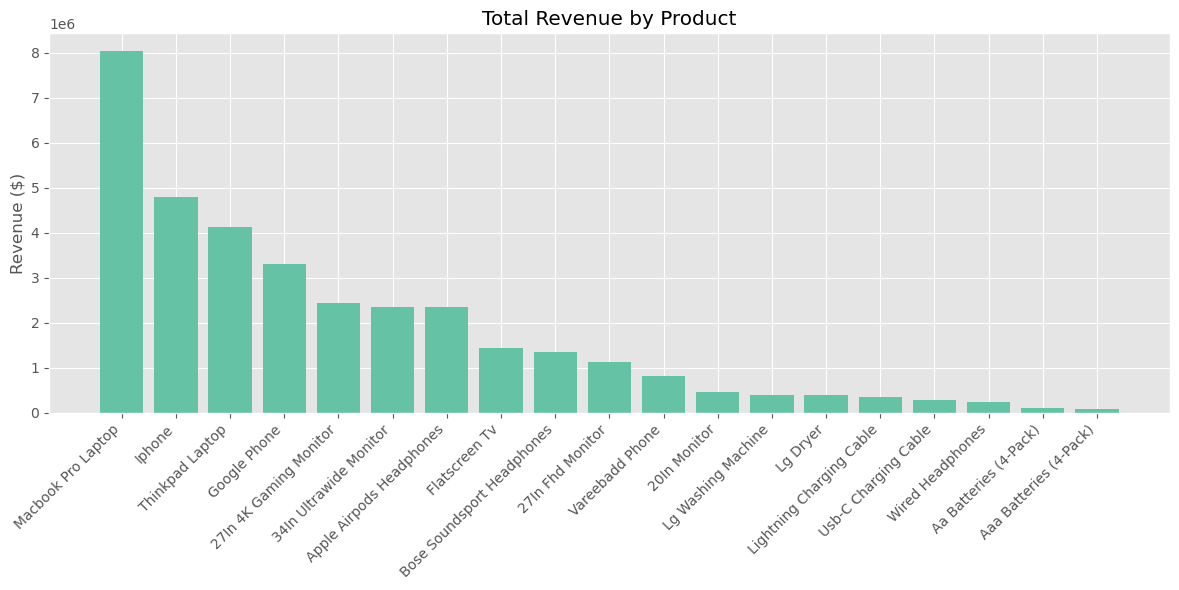

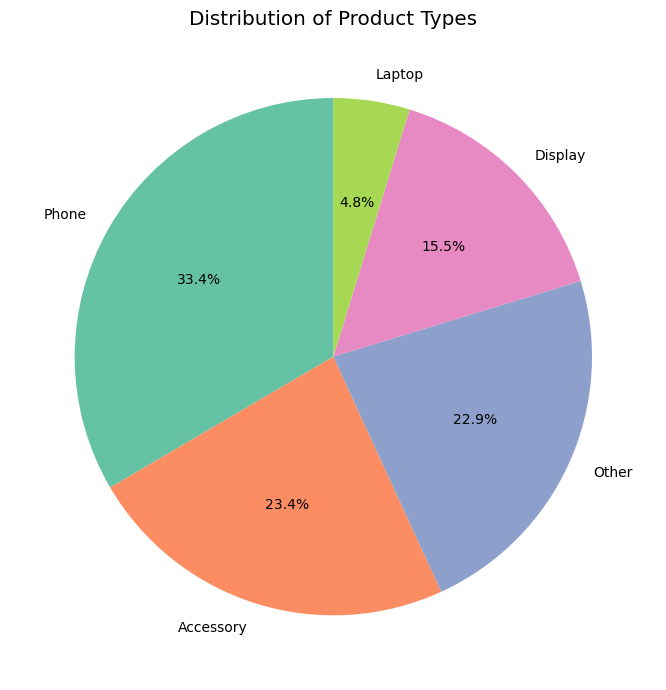

In [79]:
# ----------------- Aggregations & Graphs -----------------
plt.style.use('ggplot')
sns.set_palette("Set2")

#  Total yearly revenue by product
revenue_by_product = df_cleaned.groupby('Product', as_index=False)['Total Price'].sum().sort_values('Total Price', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(revenue_by_product['Product'], revenue_by_product['Total Price'])
plt.title("Total Revenue by Product")
plt.ylabel("Revenue ($)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#  Product type distribution (Pie Chart)
product_type_dist = df_cleaned['Product Type'].value_counts()

plt.figure(figsize=(7, 7))
product_type_dist.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Product Types")
plt.ylabel("")
plt.tight_layout()
plt.show()
